## Assignment 3

# Household Electric Power Consumption Prediction Using LSTM (Long Short-Term Memory) Neural Networks

`Hafara Firdausi (05111950010040)`

## 1. Description
### 1.1 Requirements

* Python 3.7.3
* Pandas
* Numpy
* Matplotlib
* TensorFlow
* Scikit-learn
* Jupyter Notebook (optional)

### 1.2 Dataset
Dataset used comes from **UCI Machine Learning** titled **"Individual Household Electric Power Consumption Dataset"**, a multivariate time series dataset contains **2075259** measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010.

It has 9 attributes described below:

| Attributes | Description |
|---|---|
| **date** | Date (dd/mm/yyyy) | 
| **time** | Time (hh:mm:ss)| 
| **global_active_power** | The total active power consumed by the household (Kilowatt) |
| **global_reactive_power** | The total reactive power consumed by the household (Kilowatt) |
| **voltage** | Average voltage (Volt) |
| **global_intensity** | Average current intensity (Ampere) |
| **sub_metering_1** | Active energy for kitchen, containing mainly a dishwasher, an oven and a microwave (Watt-hour of active energy) |
| **sub_metering_2** | Active energy for laundry rooms, containing a washing-machine, a tumble-drier, a refrigerator and a light (Watt-hour of active energy) |
| **sub_metering_3** | Active energy for climate control, containing an electric water-heater and an air-conditioner systems (Watt-hour of active energy)|

However, we are only interested in **Global_active_power** variable.

## 2. Steps


In [1]:
## import required packages

# basic python libraries 
import os, sys, math

# data handling
import pandas as pd # data processing, CSV file I/O, data manipulation as in SQL
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import numpy as np # linear algebra

# graph plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns 
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# statistics
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

# machine learning
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# deep learning
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import EarlyStopping

### 2.1 Load Dataset

In [2]:
# constant path
PATH = os.getcwd()
DATASET_DIR_PATH = PATH + '/dataset/'
DATASET_PATH = DATASET_DIR_PATH + 'household_power_consumption.txt'
PREPARED_DATASET_PATH = DATASET_DIR_PATH + 'household_power_consumption.csv'

In [3]:
# merged two columns 'Date' and 'Time' to 'datetime'
# convert those data to time-series type, by convert 'datetime' as an index
df = pd.read_csv(DATASET_PATH, sep=';', header=0, low_memory=False, infer_datetime_format=True, 
                parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [4]:
print('Number of rows :', df.shape[0])
print('Number of columns :', df.shape[1])
print('Attributes :', df.columns.to_list())
print('Time series starts from :', df.index.min())
print('Time series ends on :', df.index.max())

new_df = df.head(3)
new_df = new_df.append(df.tail(3))

new_df

Number of rows : 2075259
Number of columns : 7
Attributes : ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
Time series starts from : 2006-12-16 17:24:00
Time series ends on : 2010-11-26 21:02:00


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0000
2010-11-26 21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.0000
2010-11-26 21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.0000


### 2.2 Prepare and Preprocess Data

In [5]:
# check null value
df.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [6]:
df.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [7]:
# mark all missing values
df.replace('?', np.nan, inplace=True)
# make dataset numeric
df = df.astype('float32')

In [8]:
df.dtypes

Global_active_power      float32
Global_reactive_power    float32
Voltage                  float32
Global_intensity         float32
Sub_metering_1           float32
Sub_metering_2           float32
Sub_metering_3           float32
dtype: object

In [9]:
# fill missing values with a value at the same time one day ago
def fill_missing_value(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if np.isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]

![](img/1.png)

In [10]:
fill_missing_value(df.values)

In [11]:
# check null value again
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

#### 2.2.1 Export Prepared Data

In [12]:
df.to_csv(PREPARED_DATASET_PATH)

### 2.3 EDA (Exploratory Data Analysis)

#### 2.3.1 Statistical Normality Test
This statistical normality tests are used to determine if a data set is well-modeled by a normal distribution and to compute how likely it is for a random variable underlying the data set to be normally distributed.

In this case, I'll use **D’Agostino’s K-squared Test** using SciPy and we will interpret the p value as follows:

* p <= alpha: reject H0, not normal
* p > alpha: fail to reject H0, normal 

In [13]:
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics = %.3f, p = %.3f' %(stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics = 735736.314, p = 0.000
Data does not look Gaussian (reject H0)


So, this data distribution is **not normal**. Then, I also calculate **kurtosis and skewness** to determine if the data distribution departs from the normal distribution.

Kurtosis of normal distribution: 4.237163146889262
Skewness of normal distribution: 1.7888684272766113


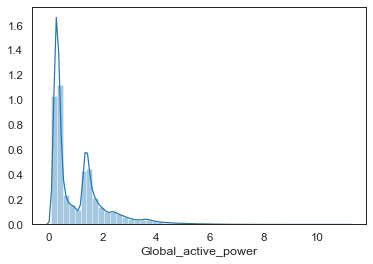

In [14]:
sns.distplot(df.Global_active_power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

* **KURTOSIS**: Describes heaviness of the tails of a distribution. Normal Distribution has a kurtosis of close to 0. If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero.

* **SKEWNESS**: If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

#### 2.3.2 Correlation Between Features
Higher correlations are brighter

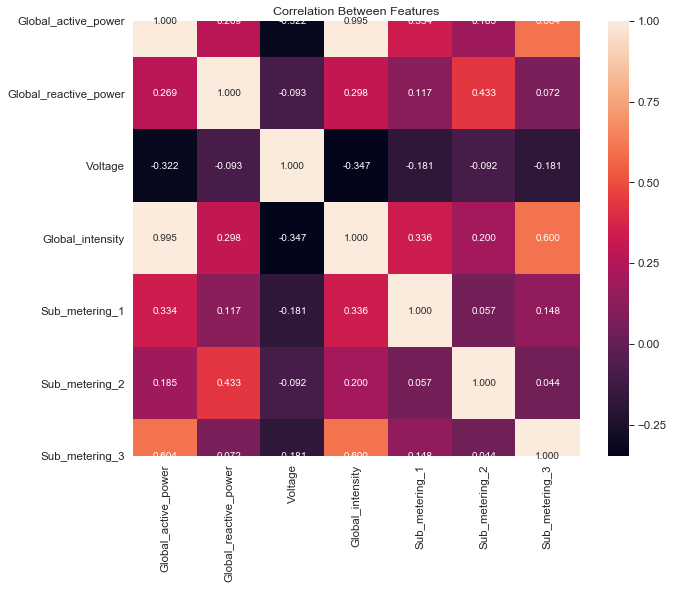

In [15]:
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.3f', ax=ax)
ax.set_title('Correlation Between Features')
plt.show()

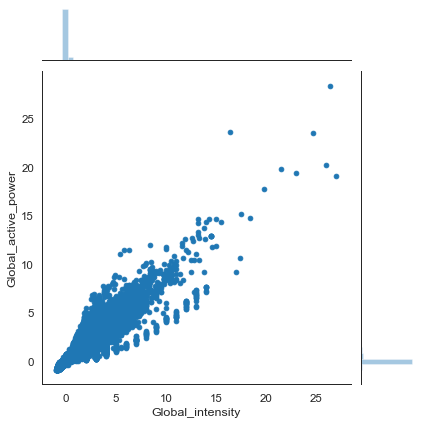

In [16]:
# Correlations between 'Global_intensity' and 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  
plt.show()

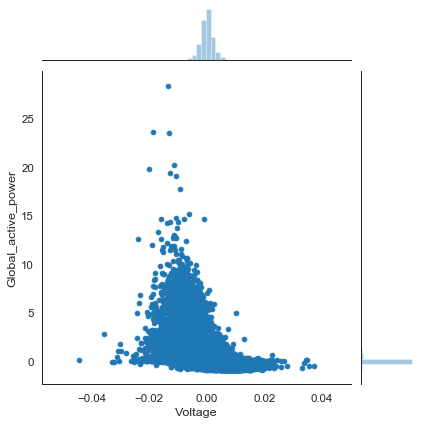

In [17]:
# Correlations between 'Voltage' and 'Global_active_power'
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  
plt.show()

From above two plots it is seen that **'Global_intensity' and 'Global_active_power' correlated**, but **'Voltage' and 'Global_active_power' are less correlated**. This is important observation for machine learning purpose.

#### 2.3.3  Yearly Global Active Power VS Quarterly Global Active Power 

In [18]:
# prepare df for analysis
df.reset_index(level=0, inplace=True)
df['year'] = df['datetime'].apply(lambda x: x.year)
df['quarter'] = df['datetime'].apply(lambda x: x.quarter)
df['month'] = df['datetime'].apply(lambda x: x.month)
df['day'] = df['datetime'].apply(lambda x: x.day)

df_compare = df.loc[:,['datetime','Global_active_power', 'year','quarter','month','day']]
df_compare.sort_values('datetime', inplace=True, ascending=True)
df_compare = df_compare.reset_index(drop=True)
df_compare["weekday"] = df_compare.apply(lambda row: row["datetime"].weekday(),axis=1)
df_compare["weekday"] = (df_compare["weekday"] < 5).astype(int)

df = df.drop(['year','quarter','month','day'], axis=1)
df = df.set_index('datetime')

In [19]:
print('Number of rows :', df_compare.shape[0])
print('Number of columns :', df_compare.shape[1])
print('Attributes :', df_compare.columns.to_list())
print('Time series starts from :', df_compare['datetime'].min())
print('Time series ends on :', df_compare['datetime'].max())

df_compare.head()

Number of rows : 2075259
Number of columns : 7
Attributes : ['datetime', 'Global_active_power', 'year', 'quarter', 'month', 'day', 'weekday']
Time series starts from : 2006-12-16 17:24:00
Time series ends on : 2010-11-26 21:02:00


,datetime,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.2160,2006,4,12,16,0
1,2006-12-16 17:25:00,5.3600,2006,4,12,16,0
2,2006-12-16 17:26:00,5.3740,2006,4,12,16,0
3,2006-12-16 17:27:00,5.3880,2006,4,12,16,0
4,2006-12-16 17:28:00,3.6660,2006,4,12,16,0


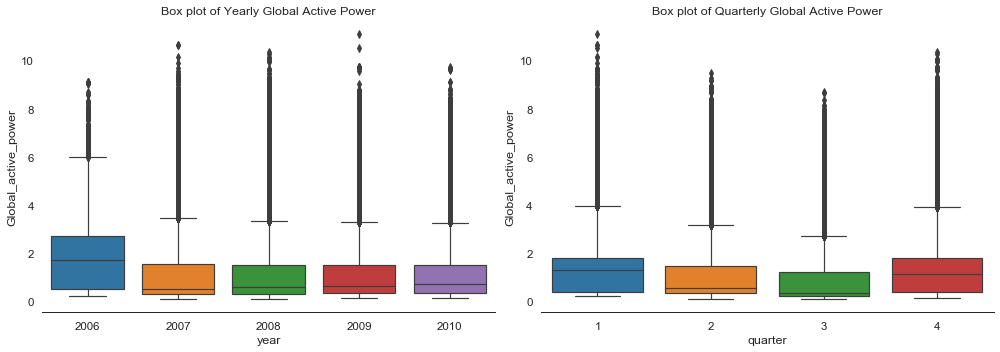

In [20]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=df_compare)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout() 

plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Global_active_power", data=df_compare)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();

**Analisis** : Median pada tahun 2006 jauh lebih tinggi daripada tahun-tahun lainnya. Perlu diingat jika data timeseries ini dimulai pada bulan Desember 2006 (musim dingin), dimana bulan ini merupakan puncak konsumsi listrik. Sedangkan jika di-boxplot berdasarkan musim/kuarter, maka mediannya lebih konsisten: kuarter 1 dan 4 lebih tinggi dibandingkan yang lain karena musim dingin, sedangkan kuarter 3 paling rendah dibandingkan yang lain karena musim panas.

dt.quarter from Pandas will divide datetime become:
* Month 1 - 3 : quarter 1
* Month 4 - 6 : quarter 2
* Month 7 - 9 : quarter 3
* Month 10 - 12 : quarter 4

But, 4 Seasons in France occur in the following month
* Spring : 3 - 5 (quarter 1)
* Summer : 6 - 8 (quarter 2)
* Autumn : 9 - 11 (quarter 3)
* Winter : 12 - 2 (quarter 4)

#### 2.3.4 Global Active Power Distribution

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2075259.0000,1.0894,1.0547,0.0760,0.3080,0.6020,1.5260,11.1220
Global_reactive_power,2075259.0000,0.1237,0.1126,0.0000,0.0480,0.1000,0.1940,1.3900
Voltage,2075259.0000,240.8364,3.2401,223.2000,238.9900,241.0000,242.8700,254.1500
Global_intensity,2075259.0000,4.6184,4.4332,0.2000,1.4000,2.6000,6.4000,48.4000
Sub_metering_1,2075259.0000,1.1185,6.1415,0.0000,0.0000,0.0000,0.0000,88.0000
Sub_metering_2,2075259.0000,1.2911,5.7969,0.0000,0.0000,0.0000,1.0000,80.0000
Sub_metering_3,2075259.0000,6.4486,8.4336,0.0000,0.0000,1.0000,17.0000,31.0000


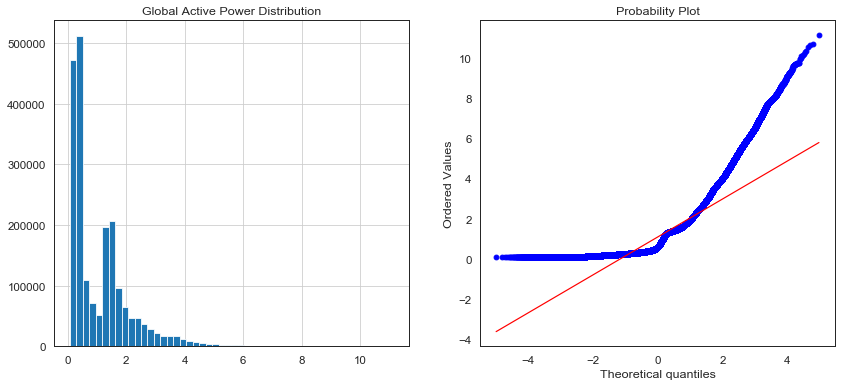

In [21]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'], plot=plt);
df.describe().T

Normal probability plot also shows the data set is **far from normally distributed**.

#### 2.3.5 Average Global Active Power Resampled Over Hour, Day, Week, Month, Quarter and Year

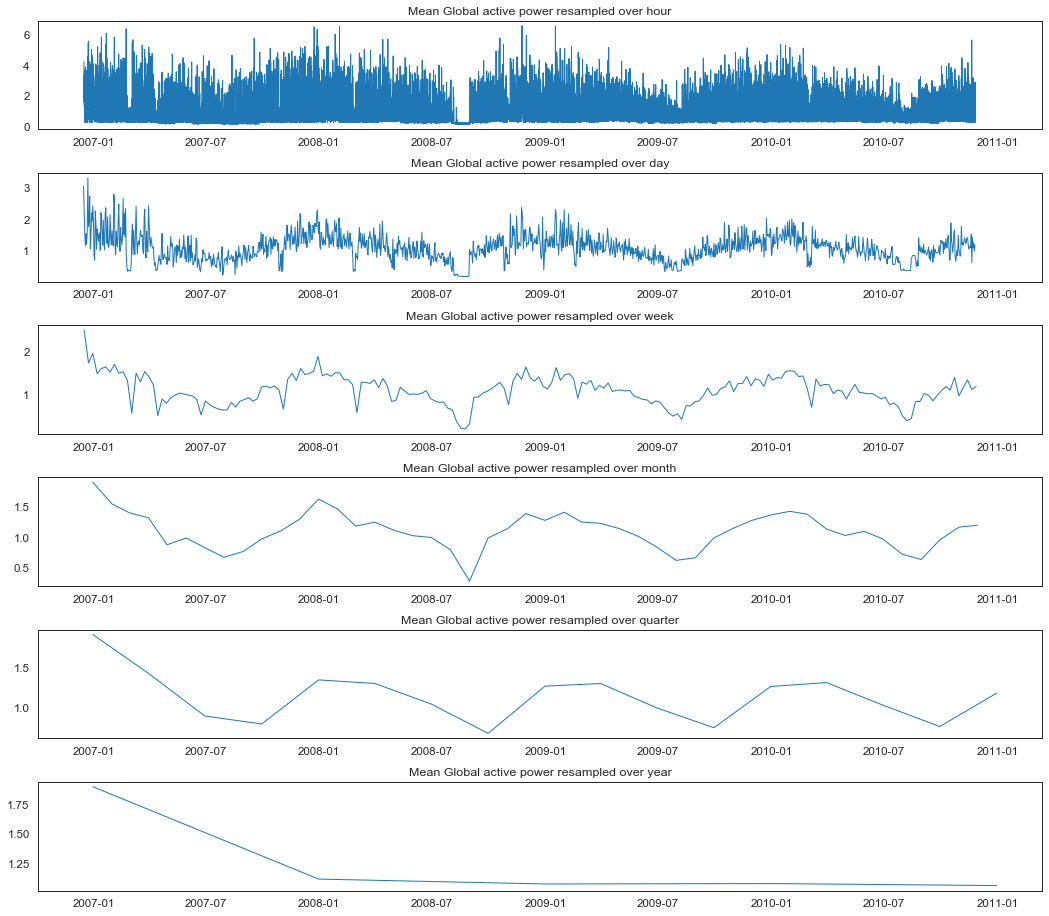

In [22]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)

ax0 = fig.add_subplot(6,1,1)
ax0.plot(df['Global_active_power'].resample('h').mean(),linewidth=1)
ax0.set_title('Mean Global active power resampled over hour')
ax0.tick_params(axis='both', which='major')

ax1 = fig.add_subplot(6,1,2, sharex=ax0)
ax1.plot(df['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(6,1,3, sharex=ax0)
ax2.plot(df['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(6,1,4, sharex=ax0)
ax3.plot(df['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(6,1,5, sharex=ax0)
ax4.plot(df['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(6,1,6, sharex=ax0)
ax5.plot(df['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

#### 2.3.6 Average Global Active Power Grouped By Year, Quarter, Month and Day

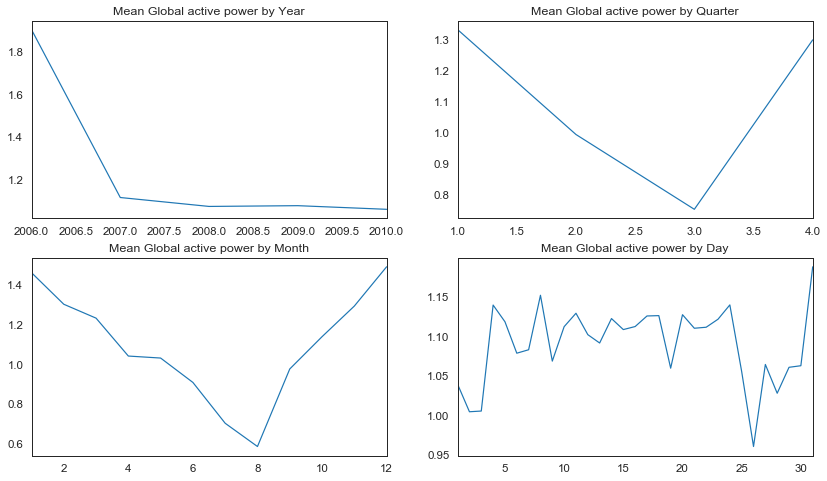

In [23]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df_compare.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df_compare.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df_compare.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df_compare.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

Pada plot berdasar tahun, konsumsi daya rata-rata tertinggi adalah sebelum 2007 dan konsisten setelahnya. Pada plot berdasar kuartal, konsumsi daya rata-rata terendah di kuartal ke-3 (musim panas). Menurut plot berdasar bulan, konsumsi daya rata-rata terendah adalah pada bulan Agustus (musim panas). Pada plot berdasar hari, konsumsi daya rata-rata terendah adalah pada hari ke 26 (tidak tahu mengapa).

#### 2.3.7 Global Active Power by Years
For 2006, we only have data for December, so remove 2006.

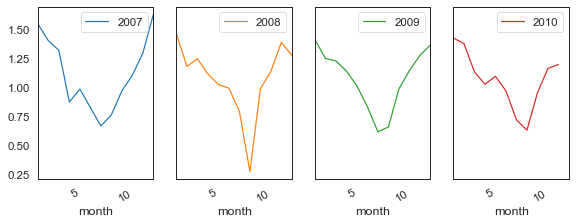

In [24]:
pd.pivot_table(df_compare.loc[df_compare['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

#### 2.3.8 Global Active Power Consumption in Weekdays vs. Weekends

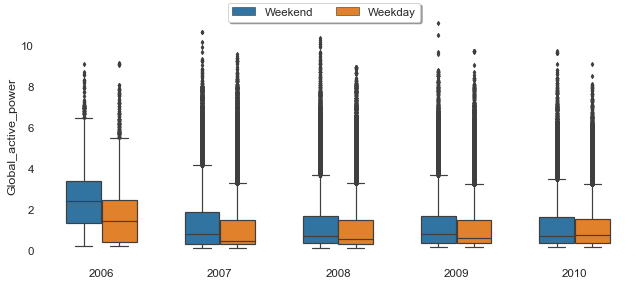

In [25]:
dic = {
    0:'Weekend',
    1:'Weekday'
}
df_compare['Day'] = df_compare.weekday.map(dic)

a = plt.figure(figsize=(9,4)) 
plt1 = sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,
                    data=df_compare)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


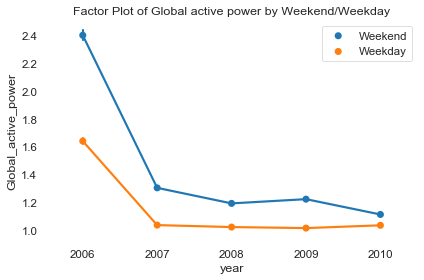

In [26]:
plt1 = sns.factorplot('year','Global_active_power',hue='Day',
                    data=df_compare, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global active power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

#### 2.3.9 Dickey-Fuller Test to Ceck Stationarity

In [27]:
df2 = df['Global_active_power'].resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


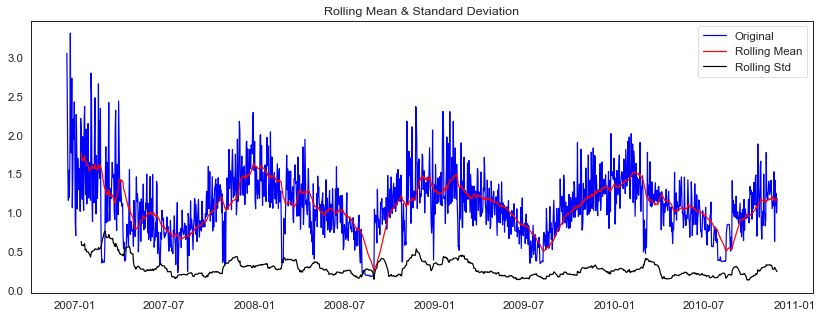

<Results of Dickey-Fuller Test>
Test Statistic                  -3.6736
p-value                          0.0045
#Lags Used                      22.0000
Number of Observations Used   1419.0000
Critical Value (1%)             -3.4350
Critical Value (5%)             -2.8636
Critical Value (10%)            -2.5679
dtype: float64


In [28]:
test_stationarity(df2)

### 2.4 LSTM

In [29]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.2160,0.4180,234.8400,18.4000,0.0000,1.0000,17.0000
2006-12-16 17:25:00,5.3600,0.4360,233.6300,23.0000,0.0000,1.0000,16.0000
2006-12-16 17:26:00,5.3740,0.4980,233.2900,23.0000,0.0000,2.0000,17.0000
2006-12-16 17:27:00,5.3880,0.5020,233.7400,23.0000,0.0000,1.0000,17.0000
2006-12-16 17:28:00,3.6660,0.5280,235.6800,15.8000,0.0000,1.0000,17.0000


Due to lack of computing resources, I'll reduce the data by resample it over hour. It will reduce the computation time too. 

For the full data:
https://colab.research.google.com/drive/14v_wt4rcI0xW5z6YwQqFH_TtdZatNszh

In [30]:
## resample data over hour
df_resample = df.resample('h').mean()

In [31]:
print('Number of rows :', df_resample.shape[0])
print('Number of columns :', df_resample.shape[1])
print('Attributes :', df_resample.columns.to_list())
print('Time series starts from :', df_resample.index.min())
print('Time series ends on :', df_resample.index.max())

df_resample.head()

Number of rows : 34589
Number of columns : 7
Attributes : ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
Time series starts from : 2006-12-16 17:00:00
Time series ends on : 2010-11-26 21:00:00


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.2229,0.2290,234.6439,18.1000,0.0000,0.5278,16.8611
2006-12-16 18:00:00,3.6322,0.0800,234.5802,15.6000,0.0000,6.7167,16.8667
2006-12-16 19:00:00,3.4002,0.0852,233.2325,14.5033,0.0000,1.4333,16.6833
2006-12-16 20:00:00,3.2686,0.0751,234.0715,13.9167,0.0000,0.0000,16.7833
2006-12-16 21:00:00,3.0565,0.0767,237.1587,13.0467,0.0000,0.4167,17.2167


#### 2.4.1 Normalize Data

In [32]:
# get values
values = df_resample.Global_active_power.values 
values

array([4.222889 , 3.6322   , 3.4002333, ..., 1.6593333, 1.1637   ,
       0.9346667], dtype=float32)

In [33]:
# check shape
values.shape

(34589,)

In [34]:
# reshape
values = np.reshape(values, (-1, 1))
values.shape

(34589, 1)

In [35]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
# lets see
values

array([[0.6368162 ],
       [0.5450449 ],
       [0.50900584],
       ...,
       [0.23853418],
       [0.16153105],
       [0.12594771]], dtype=float32)

#### 2.4.2 Split Data 
Split data become data training and data testing

In [36]:
# determine train and test size
train_size = int(len(values) * 0.80)
test_size = len(values) - train_size
print('Train size: ', train_size)
print('Test size: ', test_size)

Train size:  27671
Test size:  6918


In [37]:
# split data
train, test = values[0:train_size,:], values[train_size:len(values),:]

In [38]:
pd.DataFrame(train).head()

,0
0,0.6368
1,0.5450
2,0.5090
3,0.4885
4,0.4556


In [39]:
pd.DataFrame(test).head()

,0
0,0.0550
1,0.0825
2,0.2039
3,0.3412
4,0.3163


In [40]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [41]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [42]:
X_train.shape

(27640, 30)

In [43]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.6368,0.5450,0.5090,0.4885,0.4556,0.3226,0.3010,0.2732,0.5011,0.2273,...,0.2388,0.3059,0.4446,0.4975,0.5100,0.5551,0.4326,0.5030,0.4532,0.2166
1,0.5450,0.5090,0.4885,0.4556,0.3226,0.3010,0.2732,0.5011,0.2273,0.2390,...,0.3059,0.4446,0.4975,0.5100,0.5551,0.4326,0.5030,0.4532,0.2166,0.0487
2,0.5090,0.4885,0.4556,0.3226,0.3010,0.2732,0.5011,0.2273,0.2390,0.3250,...,0.4446,0.4975,0.5100,0.5551,0.4326,0.5030,0.4532,0.2166,0.0487,0.0237
3,0.4885,0.4556,0.3226,0.3010,0.2732,0.5011,0.2273,0.2390,0.3250,0.2910,...,0.4975,0.5100,0.5551,0.4326,0.5030,0.4532,0.2166,0.0487,0.0237,0.0294
4,0.4556,0.3226,0.3010,0.2732,0.5011,0.2273,0.2390,0.3250,0.2910,0.1832,...,0.5100,0.5551,0.4326,0.5030,0.4532,0.2166,0.0487,0.0237,0.0294,0.0249


In [44]:
Y_train.shape

(27640,)

In [45]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [46]:
X_train.shape

(27640, 1, 30)

#### 2.4.3 Model Architecture
* LSTM with 100 neurons in the first visible layer
* Dropout 20%
* 1 neuron in the output layer for predicting Global_active_power
* The model will be fit for 20 training epochs with a batch size of 70

In [47]:
# create model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

W1101 00:04:13.007030 4506805696 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [48]:
# fit network
history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

W1101 00:04:14.122544 4506805696 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 27640 samples, validate on 6887 samples
Epoch 1/20
27640/27640 [==============================] - 4s 131us/sample - loss: 0.0135 - val_loss: 0.0072
Epoch 2/20
27640/27640 [==============================] - 2s 71us/sample - loss: 0.0094 - val_loss: 0.0070
Epoch 3/20
27640/27640 [==============================] - 2s 76us/sample - loss: 0.0092 - val_loss: 0.0070
Epoch 4/20
27640/27640 [==============================] - 2s 90us/sample - loss: 0.0090 - val_loss: 0.0071
Epoch 5/20
27640/27640 [==============================] - 3s 96us/sample - loss: 0.0090 - val_loss: 0.0072
Epoch 6/20
27640/27640 [==============================] - 3s 104us/sample - loss: 0.0088 - val_loss: 0.0071
Epoch 7/20
27640/27640 [==============================] - 2s 73us/sample - loss: 0.0088 - val_loss: 0.0072
Epoch 8/20
27640/27640 [==============================] - 2s 84us/sample - loss: 0.0088 - val_loss: 0.0074
Epoch 9/20
27640/27640 [==============================] - 2s 68us/sample - loss: 0.0087 - val

In [49]:
# Training Phase
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               52400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 52,501
Trainable params: 52,501
Non-trainable params: 0
_________________________________________________________________


In [50]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.4661647276533512
Train Root Mean Squared Error: 0.6188905061782318
Test Mean Absolute Error: 0.42306473131764466
Test Root Mean Squared Error: 0.5464959393954353


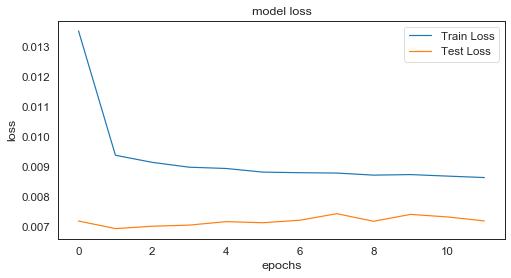

In [51]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

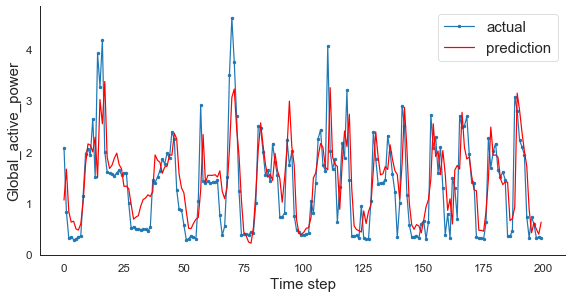

In [52]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## 3. References
* [T.-Y. Kim and S.-B. Cho, "Predicting Residential Energy Consumption Using CNN-LSTM Neural Networks," Energy, vol. 182, pp. 72-81, 2019.](https://www.sciencedirect.com/science/article/abs/pii/S0360544219311223)
* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/LSTM%20Time%20Series%20Power%20Consumption.ipynb
* [“How to Develop Multi-Step LSTM Time Series Forecasting Models for Power Usage,” *Machine Learning Mastery*, 10-Oct-2018. [Online]. Available: https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/. [Accessed: 12-Oct-2019].](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/)